### Analyzing a bike trip from Lyon to amsterdam 

We parse Strava gpx files and see what stats and plot we can make.

In [6]:
import gpxpy
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
PATH = '/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/'
p = Path(PATH)
files = list(p.rglob('*.gpx*'))

In [7]:
def load_bike_data(gpx_files_path, filter=""):
    files = list(p.rglob('*.gpx*'))
    
    track_data = []
    
    for file_idx, file in enumerate(files): 
        gpx = gpxpy.parse(open(file, 'r'))
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            track_speed = track.get_moving_data().max_speed
            
            for i, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    track_data.append([file_idx, os.path.basename(file), track_idx, track_name, 
                                     track_time, track_length, track_duration, track_speed, 
                                     i, segment_length, point.time, point.latitude, 
                                     point.longitude, point.elevation, segment.get_speed(i)])
    return track_data

In [28]:
def create_dateparts_columns(df, datetime_col, date_fmt):
    """
    Convert string date column to datetime and add date, day, weekday and hour columns to dataframe
    INPUT:
    df: pandas df
    datetime_col: name of strin datetime column in the dataframe to be converted to datetime
    date_fmt: string format of datetime column
    RETURNS:
    dataframe with extra columns
    """
    df['point_time'] = pd.to_datetime(df[datetime_col], format = date_fmt)
    df = df.assign(date = lambda x: x.point_time.dt.date,
                   day = lambda x: x.point_time.dt.day,
                   weekday = lambda x: x.point_time.dt.weekday,
                   hour = lambda x: x.point_time.dt.hour)
    return df

In [56]:
data = load_bike_data(gpx_files_path=PATH, filter="")
df = pd.DataFrame(data, columns=['file_index', 'file_name', 'index', 'etappe',
                              'time', 'length', 'duration', 'max_speed',
                              'segment_index', 'segment_length', 'point_time', 'lat',
                              'lon', 'elev', 'speed'])
# to geopandas
from shapely.geometry import Point
df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})
df['geometry'] = df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

In [57]:
df = create_dateparts_columns(df, datetime_col='point_time', date_fmt='%Y-%m-%d %H:%M:%S')

In [58]:
df['length'] /= 1e3 #?
df['segment_length'] /= 1e3

In [59]:
df.etappe.value_counts()

Étape 7# Bâle - Saint Dié des Vosges                    7859
Étape 4# Sion - Locarno                                 7843
Étape 3# Aoste - Sion                                   7527
Étape 5# Locarno - Lucerne : St Gotthard via Tremola    7355
Étape 2# Albertville - Aoste                            7102
Étape 11# Achouffe - Eindhoven                          7034
Étape 10# Verdun - Achouffe                             6375
Étape 1 # Lyon - Albertville                            5823
Étape 6# Lucerne - Bâle et la canicule                  4276
Étape 12# Eindhoven - Amsterdam !!! XXX !!!             3773
Étape 9# Nancy - Verdun                                 3736
Étape 8# Saint Dié - Nancy                              3544
Name: etappe, dtype: int64

In [60]:
df.head(1)

,file_index,file_name,index,etappe,time,length,duration,max_speed,segment_index,segment_length,point_time,lat,lon,elev,speed,geometry,date,day,weekday,hour
0,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,2018-08-09 04:26:22,212.903315,43775,13.2689,0,212.903315,2018-08-09 04:26:22,50.164228,5.67349,412.8,5.082558,POINT (5.67349 50.164228),2018-08-09,9,3,4


In [93]:
df['duration'] = df['duration']/60/60

In [92]:
28979/60/60


8.049722222222222

In [95]:
df.groupby(['etappe']).duration.mean()

etappe
Étape 1 # Lyon - Albertville                             7.999167
Étape 10# Verdun - Achouffe                              9.987222
Étape 11# Achouffe - Eindhoven                          12.159722
Étape 12# Eindhoven - Amsterdam !!! XXX !!!              5.913889
Étape 2# Albertville - Aoste                             9.110278
Étape 3# Aoste - Sion                                    9.609722
Étape 4# Sion - Locarno                                 11.135000
Étape 5# Locarno - Lucerne : St Gotthard via Tremola     9.608889
Étape 6# Lucerne - Bâle et la canicule                   6.367778
Étape 7# Bâle - Saint Dié des Vosges                    10.859444
Étape 8# Saint Dié - Nancy                               6.270000
Étape 9# Nancy - Verdun                                  5.138889
Name: duration, dtype: float64

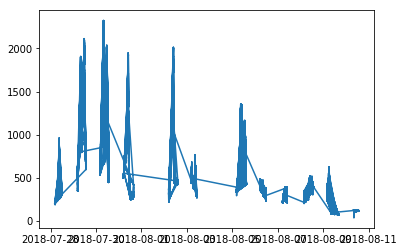

In [81]:
df = df.sort_values(by='time', ascending=False)
plt.plot(df['point_time'], df['elev'])

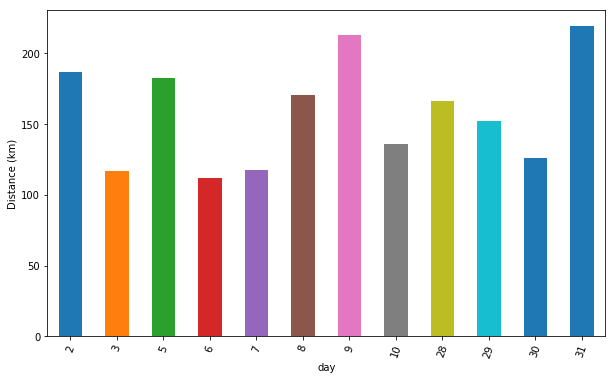

In [62]:
fig, ax = plt.subplots(figsize=[10,6])
tracks_grouped = df.groupby(['day'])
tracks_grouped['segment_length'].mean().plot(kind='bar', ax=ax)
xlabels = [text.get_text() for text in  ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=70)
_ = ax.set_ylabel('Distance (km)')

In [63]:
def clear_frame(ax): 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.values(): 
        spine.set_visible(False)

In [86]:
df['index'].value_counts()

0    72247
Name: index, dtype: int64

In [45]:
len(num_cols)

5

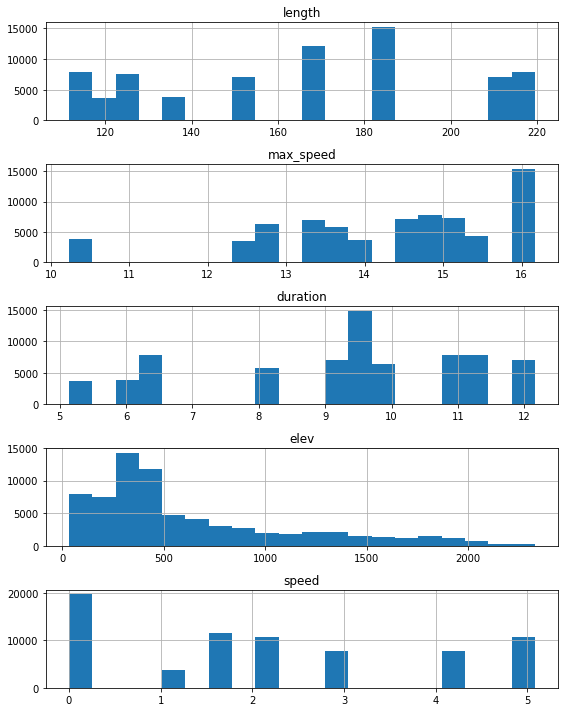

In [96]:
num_cols = ['length', 'max_speed', 'duration', 'elev', 'speed']
fig, ax = plt.subplots(len(num_cols), 1, figsize= [8,10])

for i, col in enumerate(df[num_cols].columns):
    df[col].hist(bins=20, ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()

In [231]:
df['elev_bins'] = pd.cut(df['elev'], bins = [0, 500, 1000, 1500, 2000], 
                         labels=['0-500', '500-1000', '1000-1500', '1500-2000'])

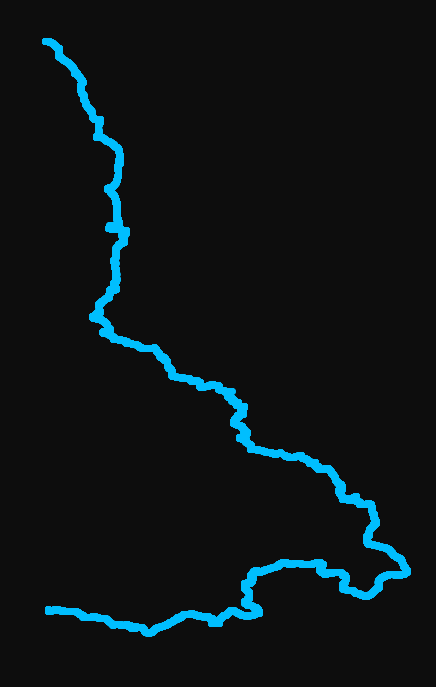

In [234]:
fig,ax = plt.subplots(figsize = [12,12], facecolor = '0.05')
ax.set_aspect('equal')
ax.set_axis_off()
df.plot(color = 'deepskyblue', lw = 0.9, alpha = 0.8, ax=ax)